# Poisson regression (GAM) COVID-19 Prediction

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plotly.offline.init_notebook_mode()
sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [2]:
# Read in data
data_path = '../data/timeseries_prov'
cases_provinces = pd.read_csv(data_path + '/cases_timeseries_prov.csv')
active_cases_provinces = pd.read_csv(data_path +  '/active_timeseries_prov.csv')
mortality_provinces = pd.read_csv(data_path + '/mortality_timeseries_prov.csv')
recovered_provinces = pd.read_csv(data_path + '/recovered_timeseries_prov.csv')

# Province population data
prov_map = {
    'British Columbia': 'BC',
    'Newfoundland and Labrador': 'NL', 
    'Northwest Territories': 'NWT',
    'Prince Edward Island': 'PEI'
}

province_populations = (
    pd.read_csv('../data/canada_prov_population.csv')
    .rename(columns = {'GEO': 'province', 'VALUE': 'population'})
    .replace({'province': prov_map})
    .loc[:, ['province', 'population']]
)


# Preprocessing dataframes to be merged
recovered_provinces = recovered_provinces.rename(columns = {'date_recovered': 'date'}).loc[:, ['province', 'date', 'recovered']]
mortality_provinces = mortality_provinces.rename(columns = {'date_death_report': 'date'}).loc[:, ['province', 'date', 'deaths']]

# Preprocessing
format = "%d-%m-%Y"
active_cases_provinces = (
    active_cases_provinces
    .rename(columns = {"date_active": "date"})
    
    # Merge deaths and recovered data
    .merge(mortality_provinces, how='left', on=['province', 'date'])
    .merge(recovered_provinces, how='left', on=['province', 'date'])
    .fillna(0)
    
    # Format date and add new cases data
    .assign(date = lambda x: pd.to_datetime(x["date"], format=format).dt.date,
            cases = cases_provinces['cases'])
    .query('province != "Repatriated"')
    
    # Add population data per province
    .merge(province_populations, how='left', on='province')
    
    # Add transformed variables
    .assign(removed = lambda x: x['recovered'] + x['deaths'],
            susceptible = lambda x: x['population'] - x['cumulative_cases'],
            percent_susceptible = lambda x: x['susceptible'] / x['population'])
)

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Save dataframe
active_cases_provinces.to_csv('../data/active_cases_provinces.csv')

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0     0.0        0.0   
1                  0             0                    0     0.0        0.0   
2                  0             0                    0     0.0        0.0   
3                  0             0                    0     0.0        0.0   
4                  0             0                    0     0.0        0.0   
5                  0             0                    0     0.0        0.0   
6                  0             0                    0     0.0        0.0   
7                  0             0                    0     0.0        0.0   
8                  0             0                    0     0.0        0.0   
9                  0             0                    0     0.0        0.0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876      0.0      4421876                  1.0  
1      0     4421876      0.0      4421876                  1.0  
2      0     4421876      0.0      4421876                  1.0  
3      0     4421876      0.0      4421876                  1.0  
4      0     4421876      0.0      4421876                  1.0  
5      0     4421876      0.0      4421876                  1.0  
6      0     4421876      0.0      4421876                  1.0  
7      0     4421876      0.0      4421876                  1.0  
8      0     4421876      0.0      4421876                  1.0  
9      0     4421876      0.0      4421876                  1.0

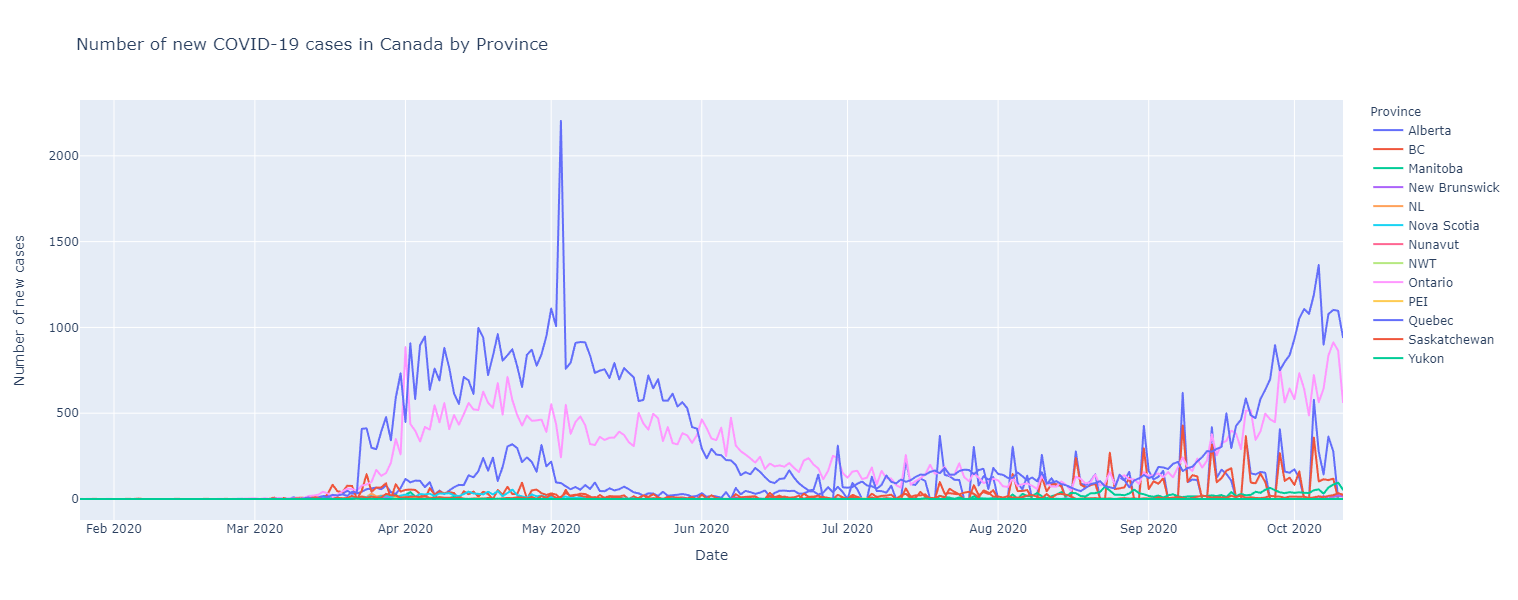

In [3]:
# Plot Y_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cases",
    color="province",
    title="Number of new COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cases="Number of new cases",
        province="Province",
    ),
    height=600,
)
fig.show()

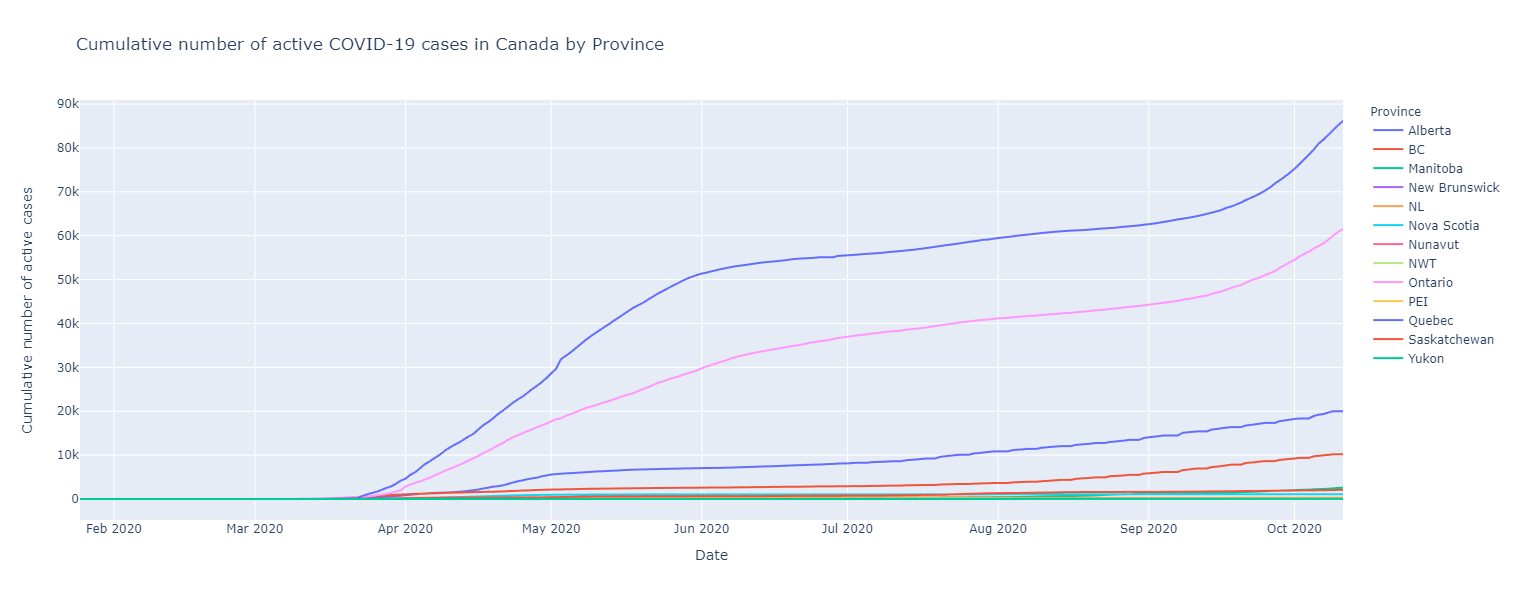

In [4]:
# Plot C_it cumulative active cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cumulative_cases",
    color="province",
    title="Cumulative number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cumulative_cases="Cumulative number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

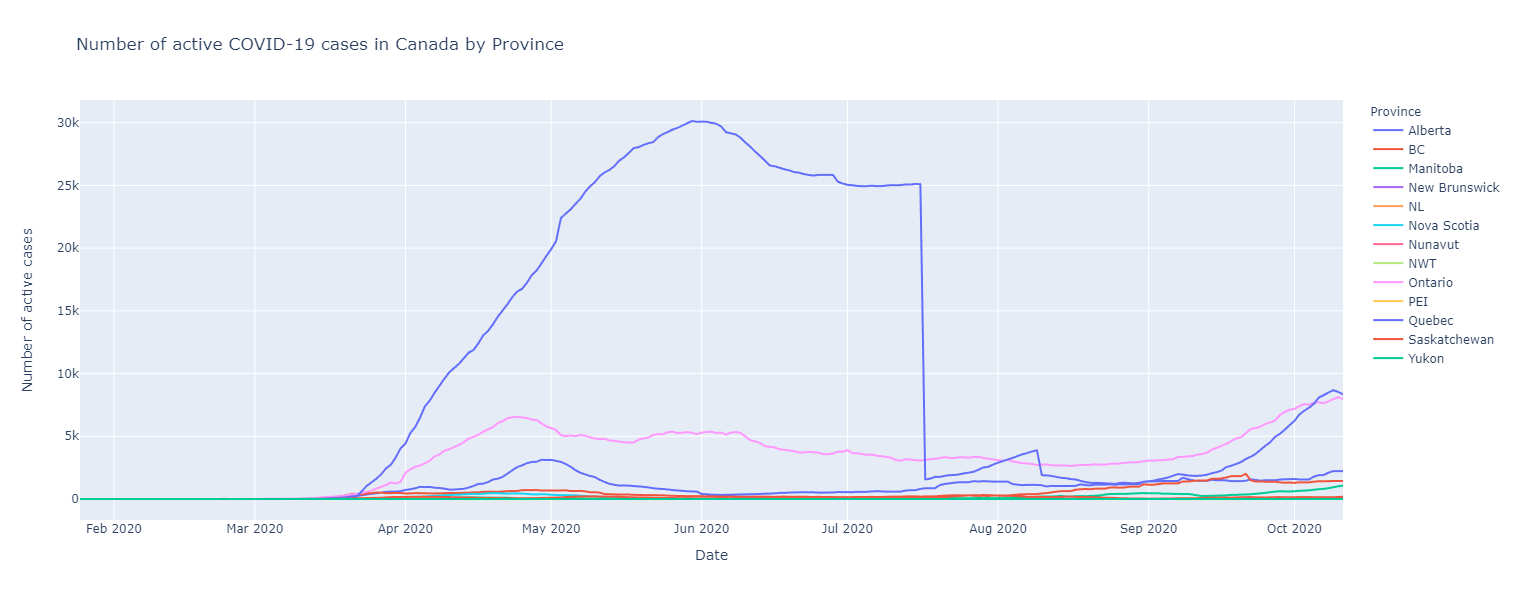

In [5]:
# Plot I_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="active_cases",
    color="province",
    title="Number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        active_cases="Number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

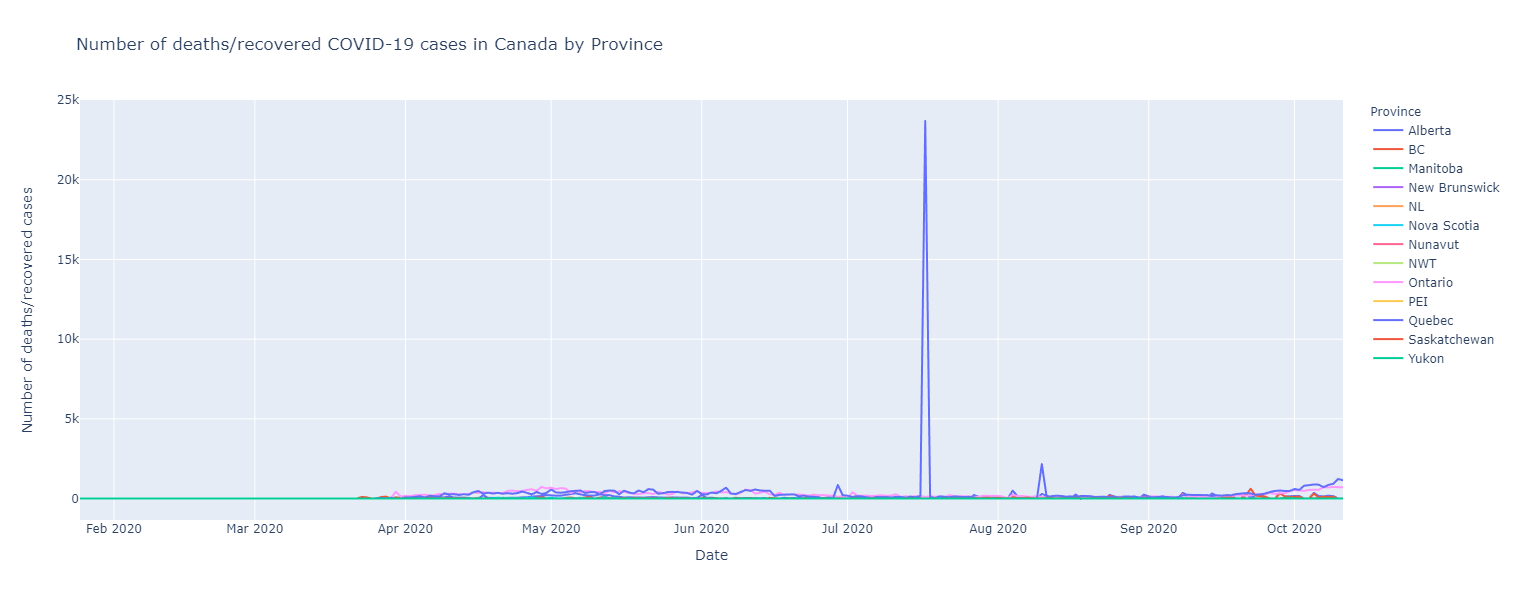

In [6]:
# Plot delta D_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="removed",
    color="province",
    title="Number of deaths/recovered COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        removed="Number of deaths/recovered cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [7]:
# Check latest date of data for each province
active_cases_provinces.sort_values('date').groupby('province').tail(1)

province        date  cumulative_cases  cumulative_recovered  \
1043  New Brunswick  2020-10-11               272                   199   
2348        Ontario  2020-10-11             61464                 50437   
1304             NL  2020-10-11               282                   269   
3131   Saskatchewan  2020-10-11              2092                  1888   
2087            NWT  2020-10-11                 5                     5   
1565    Nova Scotia  2020-10-11              1092                  1023   
1826        Nunavut  2020-10-11                 0                     0   
2870         Quebec  2020-10-11             86133                 71839   
521              BC  2020-10-11             10185                  8502   
782        Manitoba  2020-10-11              2578                  1483   
2609            PEI  2020-10-11                63                    58   
260         Alberta  2020-10-11             19995                 17488   
3392          Yukon  2020-10-11                15                    15   

      cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
1043                  2            71                   14     0.0        0.0   
2348               3049          7978                 -143     2.0      705.0   
1304                  4             9                    0     0.0        0.0   
3131                 25           179                   18     1.0        5.0   
2087                  0             0                    0     0.0        0.0   
1565                 65             4                   -1     0.0        1.0   
1826                  0             0                    0     0.0        0.0   
2870               5953          8341                 -204     3.0     1143.0   
521                 245          1438                    0     0.0        0.0   
782                  32          1063                   46     0.0        8.0   
2609                  0             5                    2     0.0        0.0   
260                 282          2225                    0     0.0        0.0   
3392                  0             0                    0     0.0        0.0   

      cases  population  removed  susceptible  percent_susceptible  
1043     14      781476      0.0       781204             0.999652  
2348    564    14734014    707.0     14672550             0.995828  
1304      0      522103      0.0       521821             0.999460  
3131     24     1178681      6.0      1176589             0.998225  
2087      0       45161      0.0        45156             0.999889  
1565      0      979351      1.0       978259             0.998885  
1826      0       39353      0.0        39353             1.000000  
2870    942     8574571   1146.0      8488438             0.989955  
521       0     5147712      0.0      5137527             0.998021  
782      54     1379263      8.0      1376685             0.998131  
2609      2      159625      0.0       159562             0.999605  
260       0     4421876      0.0      4401881             0.995478  
3392      0       42052      0.0        42037             0.999643

In [8]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

### Comments

- Seems to be a seasonal component in the $Y_{it}$ plot of about 1 week appeearing roughly on Mondays and Tuesdays. This could be that the most testing happens over the weekends and thus the cases are displayed the start of the next week.
- Large dip in active cases in Quebec on July 17 - https://globalnews.ca/news/7190163/canada-coronavirus-cases-july-17/
- Spike in new cases in Quebec on May 3- https://www.cbc.ca/news/canada/montreal/covid-19-quebec-may-3-1.5553881
- Warning: Innacurate measurements of new and active cases, recovered, deaths, etc such as this could add too much noise and lead to poor model performance. Might be a good idea to ignore that portion of Quebec and use the latest data instead.
- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 
- We will also be ignoring provinces with very few cases as they don't provide much information and predicting covid cases for those provinces is not as important as the major provinces

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [40]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

# Fit model
model = StemPoissonRegressor(lam_main=0.2, lam_other=50)
model.fit(X, Y)

In [44]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred  cases_pred  removed_pred  \
1656       Ontario  2020-10-31        7900.907867  611.186582    616.670168   
1657        Quebec  2020-10-31        7676.112824  887.962111    935.470626   
1658  Saskatchewan  2020-10-31         178.980379   11.310090     11.311420   
1659       Alberta  2020-11-01        2213.068231  183.171313    183.974556   
1660            BC  2020-11-01        1437.701557  103.587864    103.607077   
1661      Manitoba  2020-11-01        1063.323867   66.828757     66.804663   
1662   Nova Scotia  2020-11-01           3.999979    0.456200      0.456203   
1663       Ontario  2020-11-01        7895.259426  609.982699    615.631141   
1664        Quebec  2020-11-01        7627.205561  884.473245    933.380508   
1665  Saskatchewan  2020-11-01         178.979012   11.314695     11.316063   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1656        True               NaN                   NaN                NaN   
1657        True               NaN                   NaN                NaN   
1658        True               NaN                   NaN                NaN   
1659        True               NaN                   NaN                NaN   
1660        True               NaN                   NaN                NaN   
1661        True               NaN                   NaN                NaN   
1662        True               NaN                   NaN                NaN   
1663        True               NaN                   NaN                NaN   
1664        True               NaN                   NaN                NaN   
1665        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1656           NaN                  NaN     NaN        NaN    NaN         NaN   
1657           NaN                  NaN     NaN        NaN    NaN         NaN   
1658           NaN                  NaN     NaN        NaN    NaN         NaN   
1659           NaN                  NaN     NaN        NaN    NaN         NaN   
1660           NaN                  NaN     NaN        NaN    NaN         NaN   
1661           NaN                  NaN     NaN        NaN    NaN         NaN   
1662           NaN                  NaN     NaN        NaN    NaN         NaN   
1663           NaN                  NaN     NaN        NaN    NaN         NaN   
1664           NaN                  NaN     NaN        NaN    NaN         NaN   
1665           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1656      NaN          NaN                  NaN  
1657      NaN          NaN                  NaN  
1658      NaN          NaN                  NaN  
1659      NaN          NaN                  NaN  
1660      NaN          NaN                  NaN  
1661      NaN          NaN                  NaN  
1662      NaN          NaN                  NaN  
1663      NaN          NaN                  NaN  
1664      NaN          NaN                  NaN  
1665      NaN          NaN                  NaN

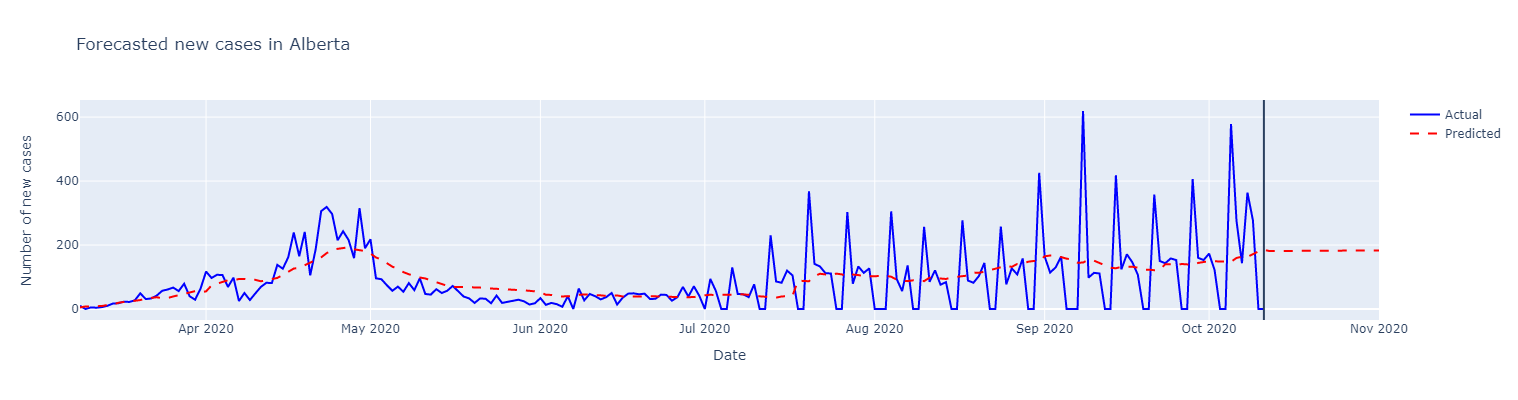

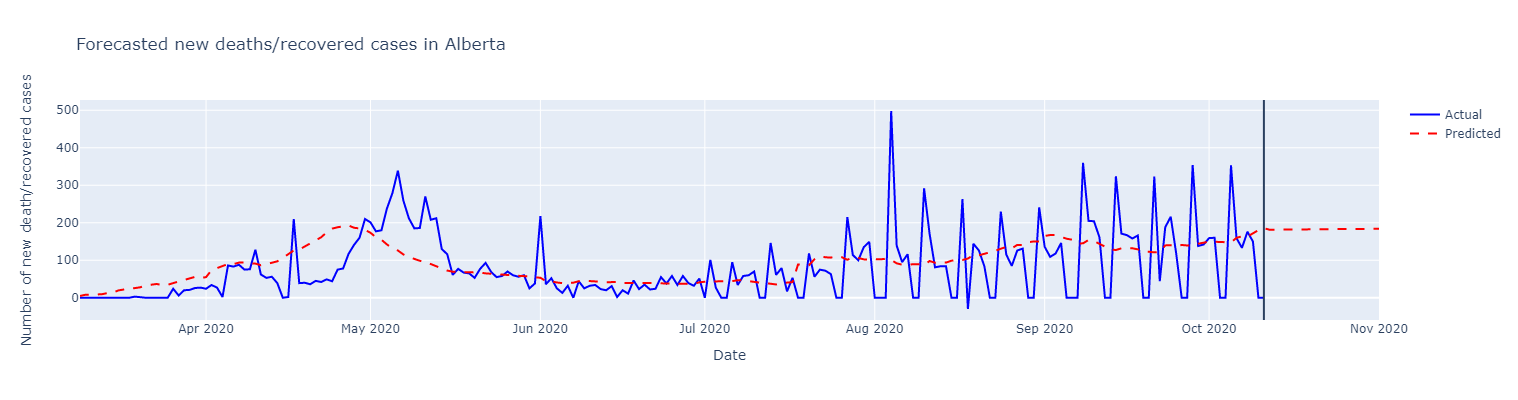

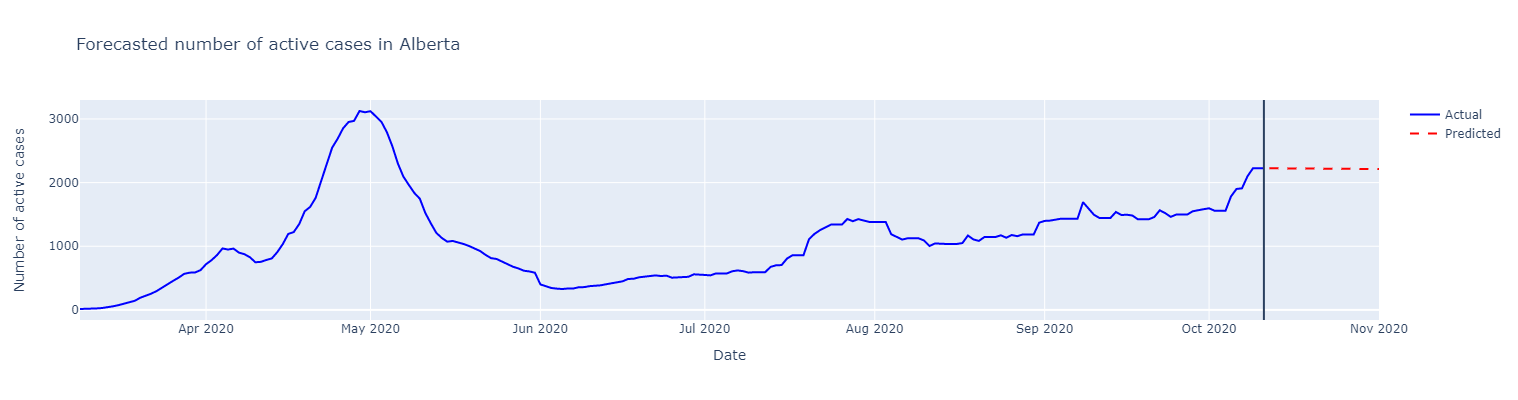

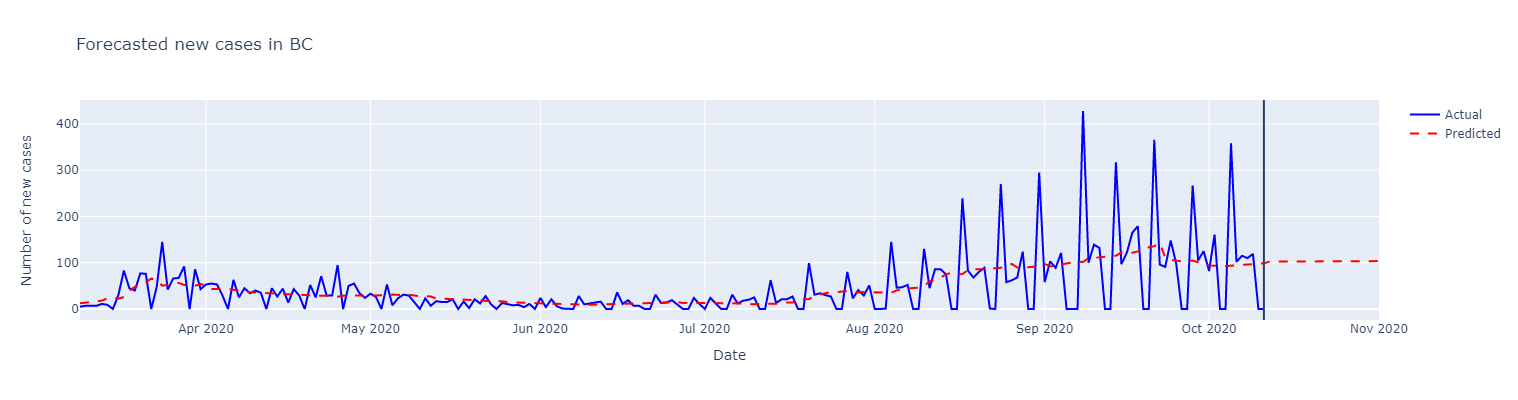

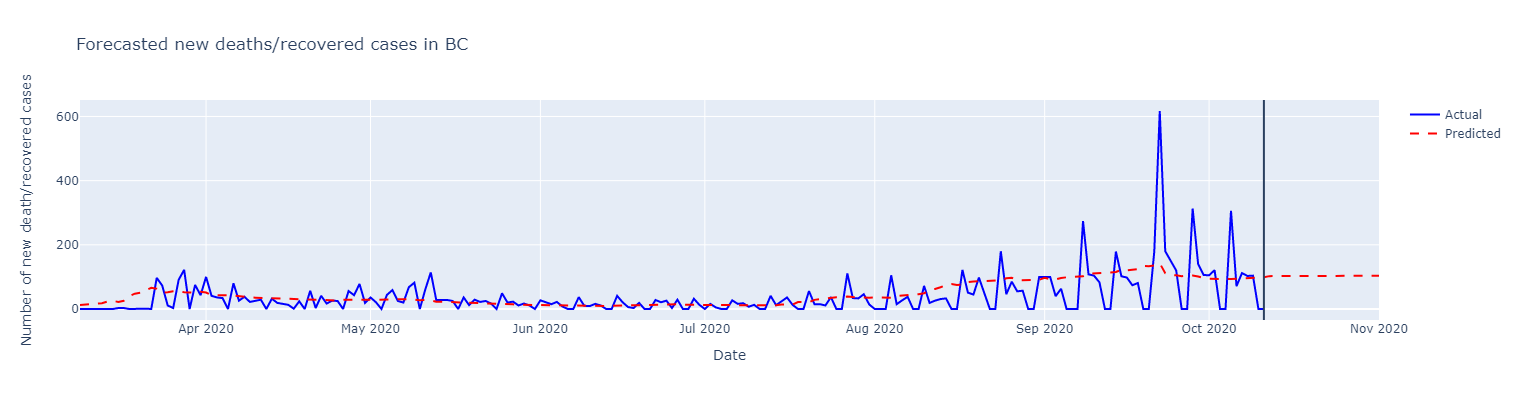

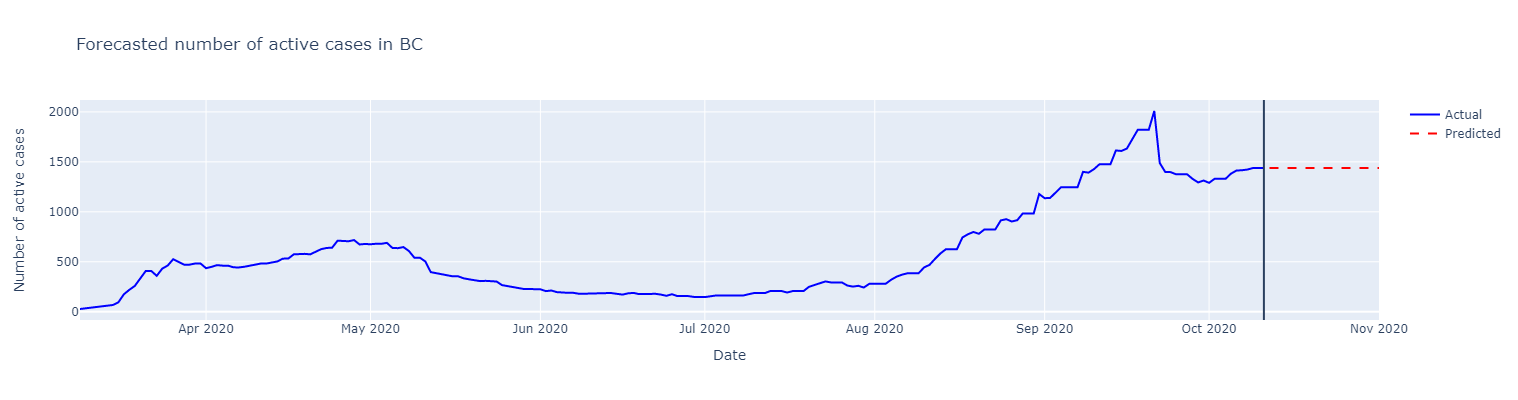

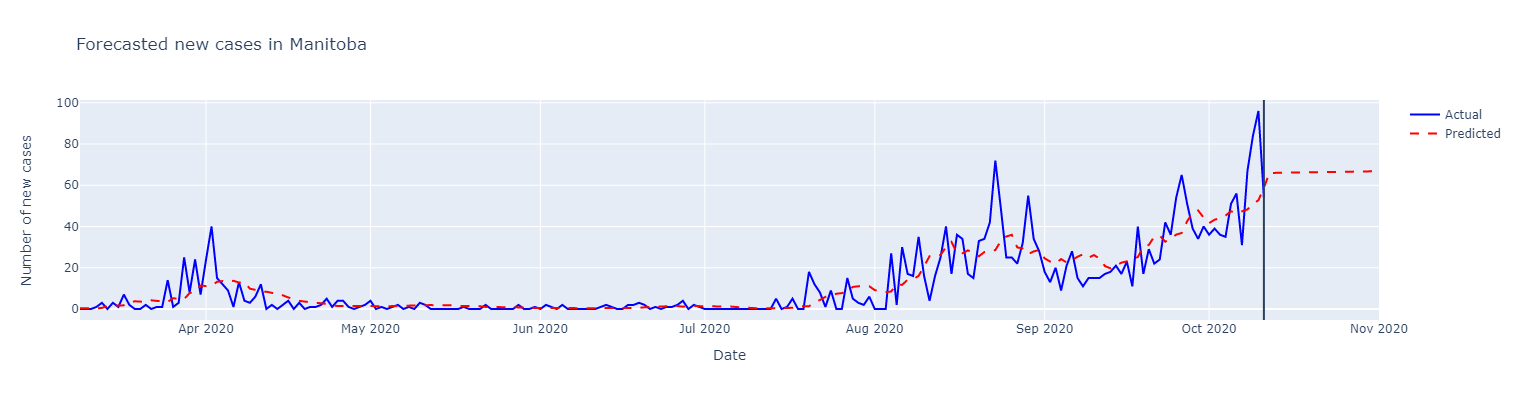

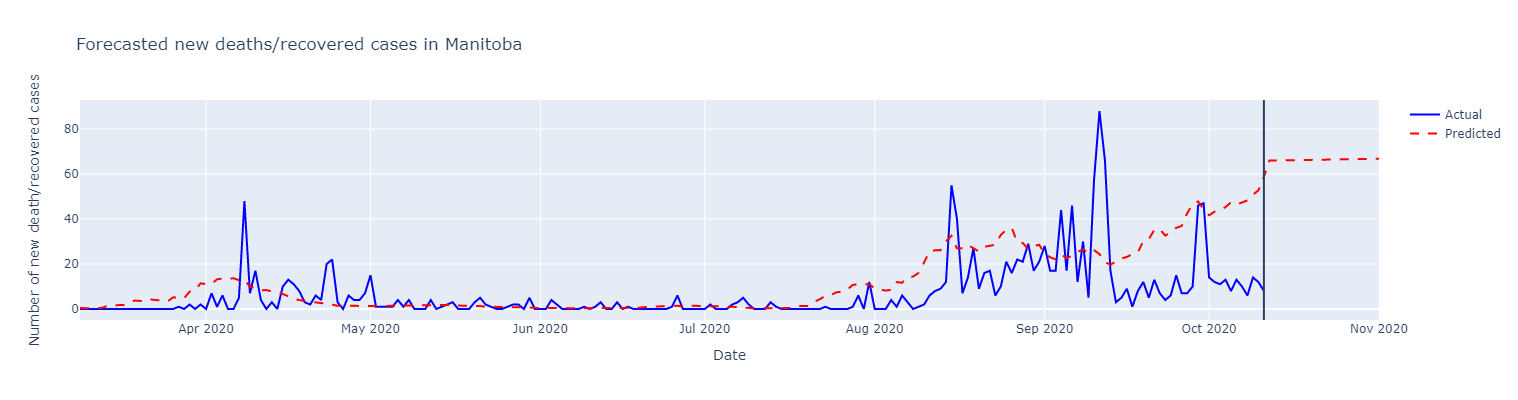

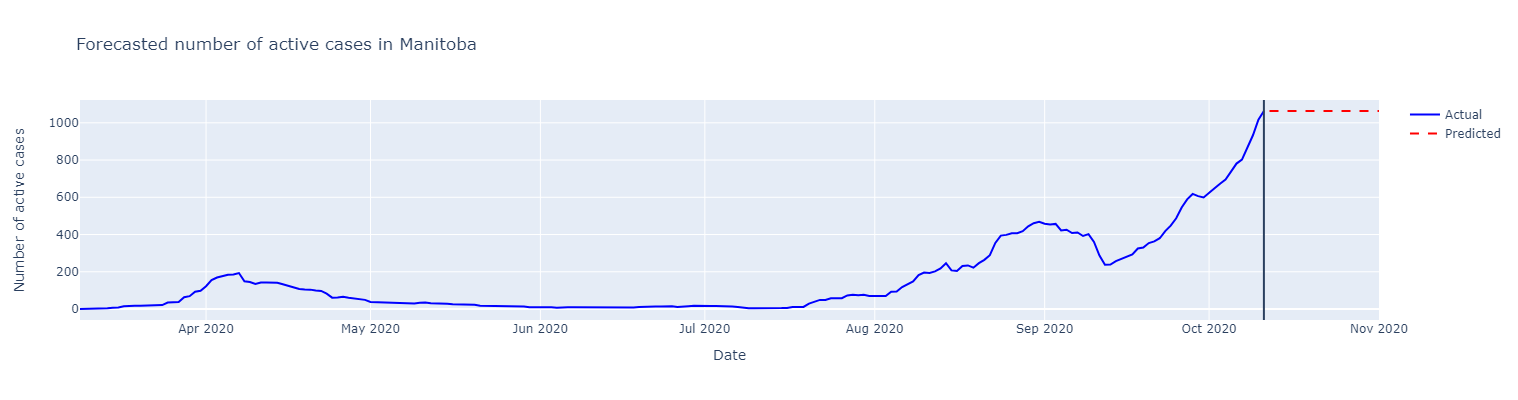

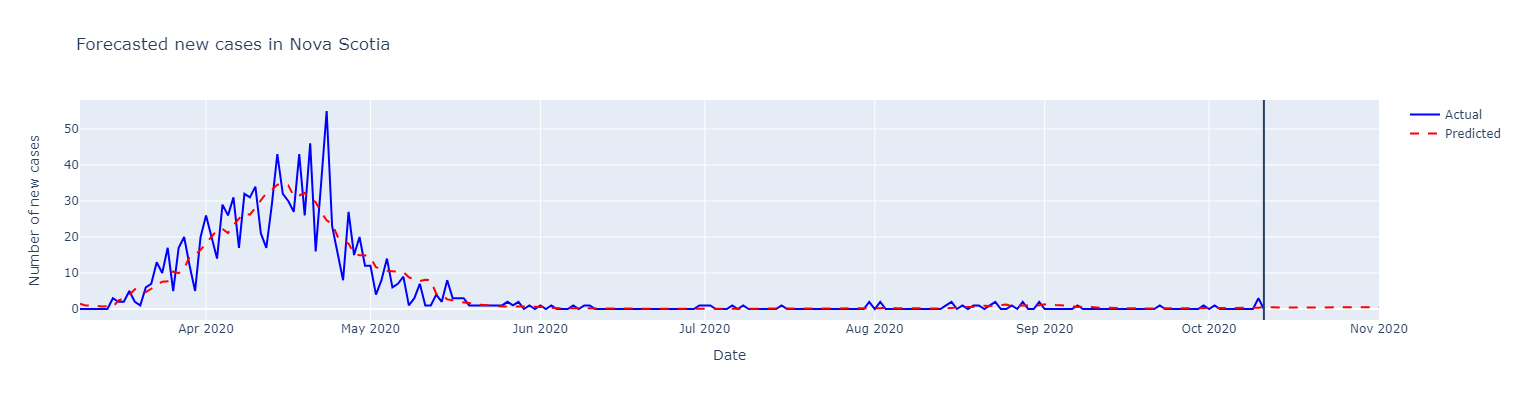

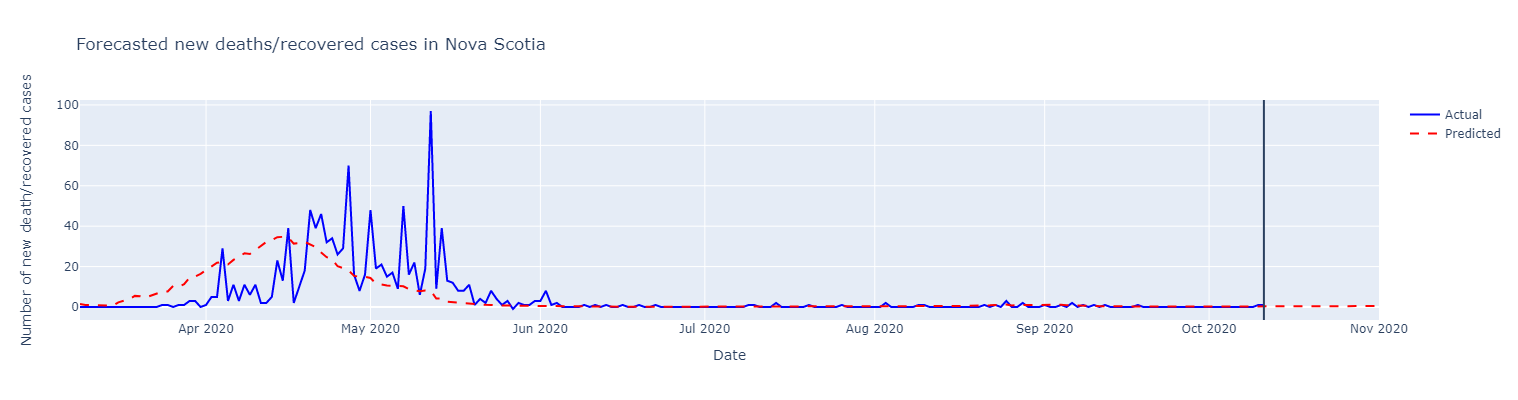

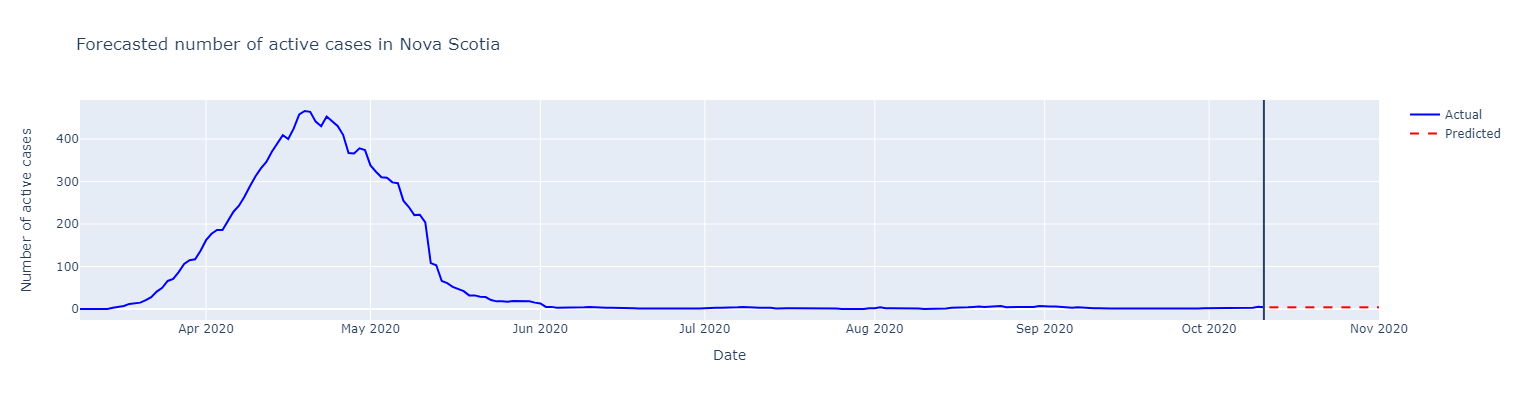

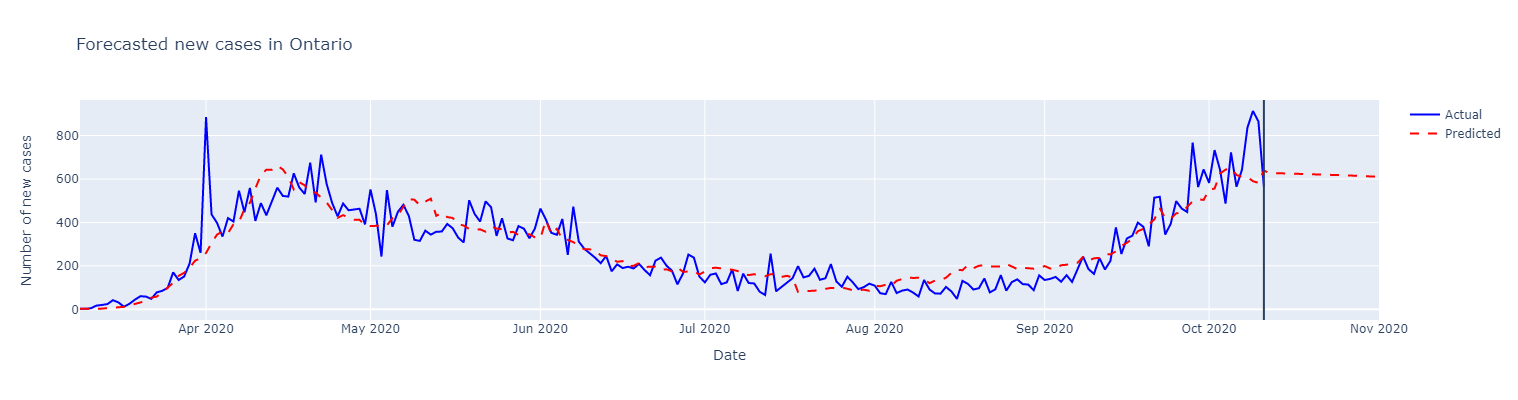

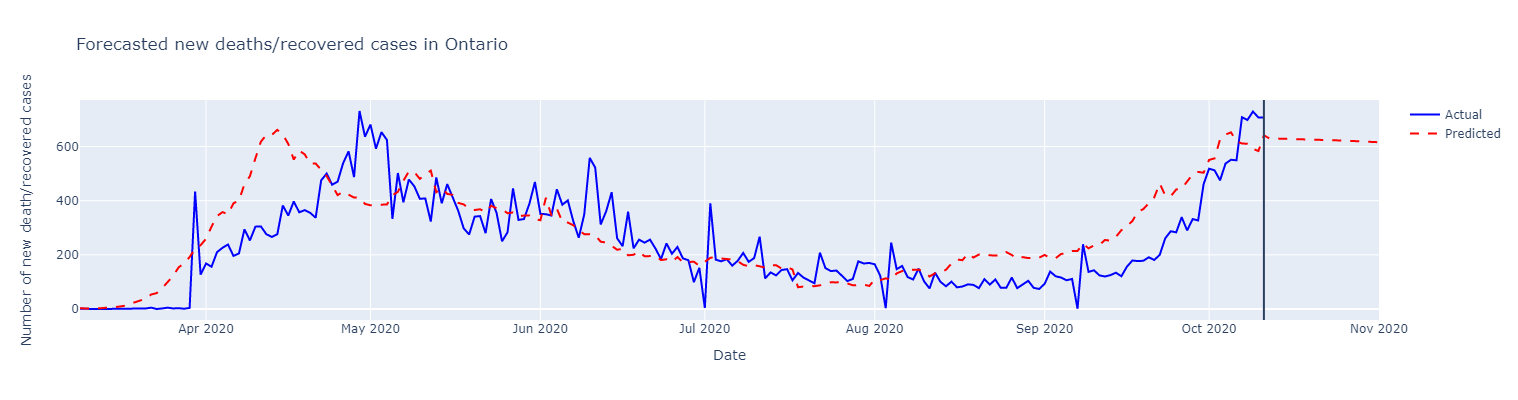

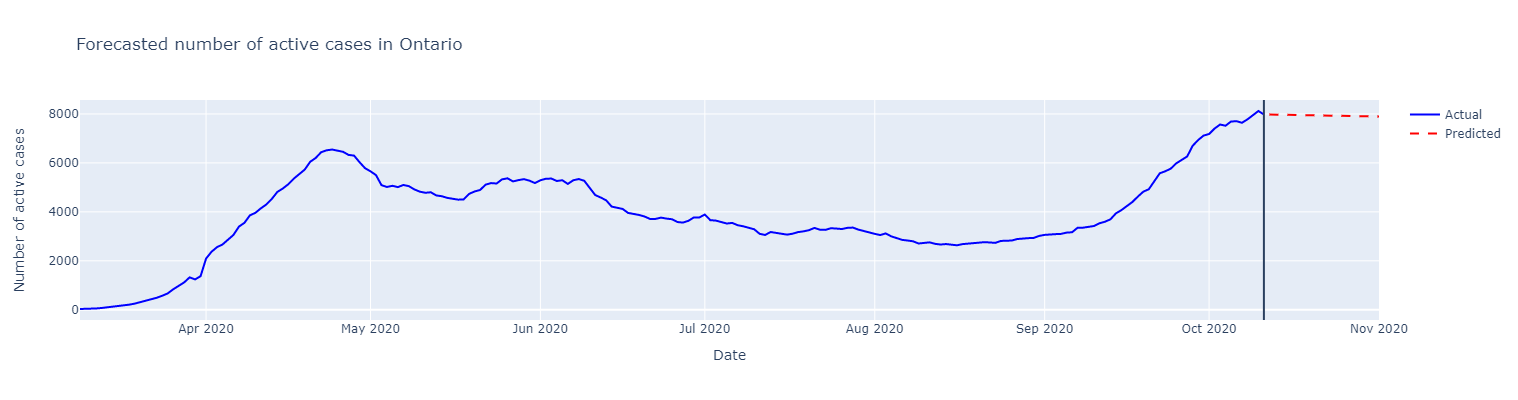

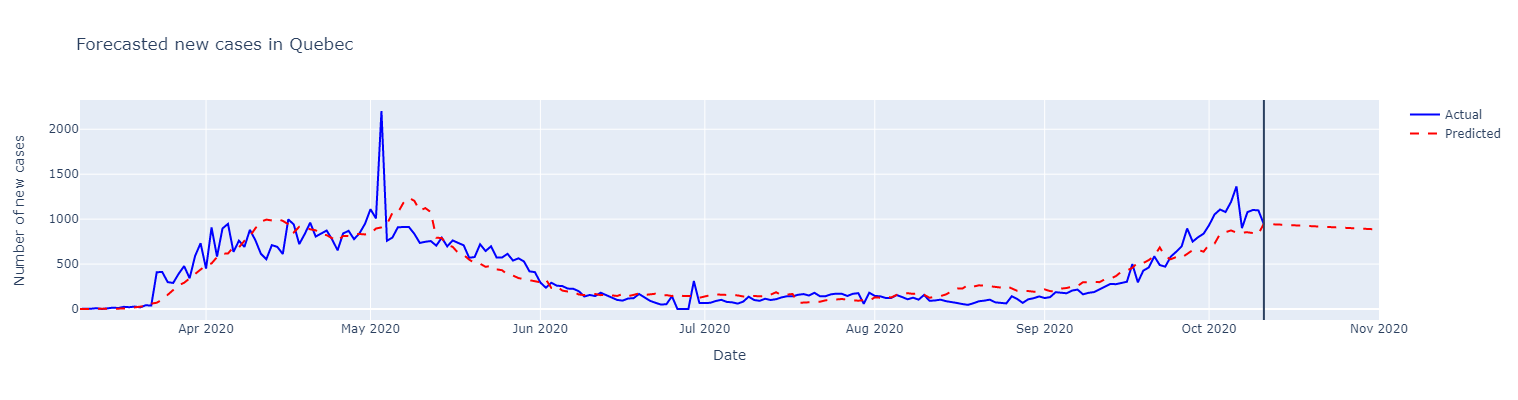

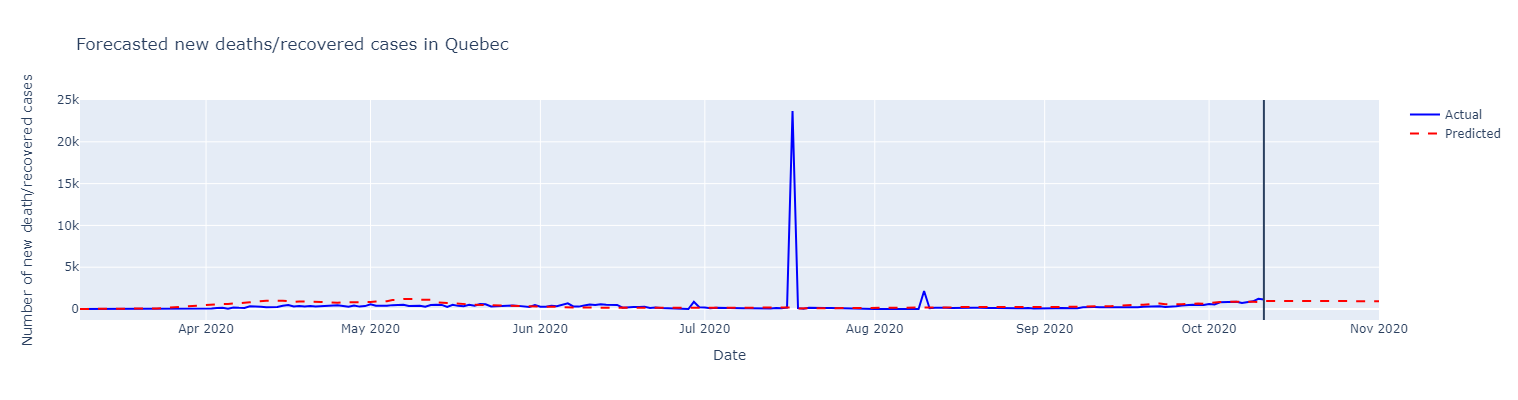

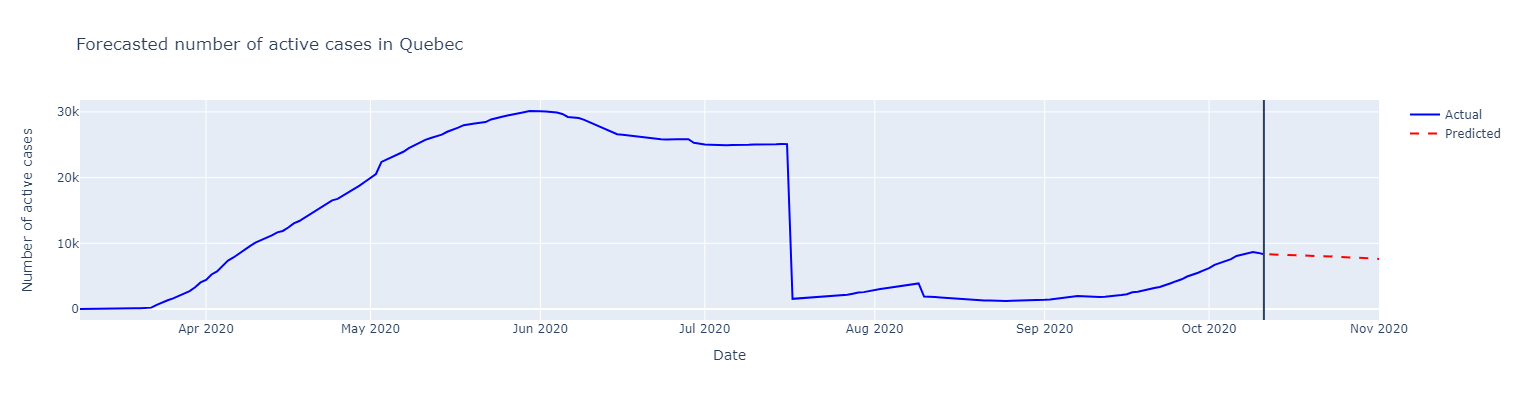

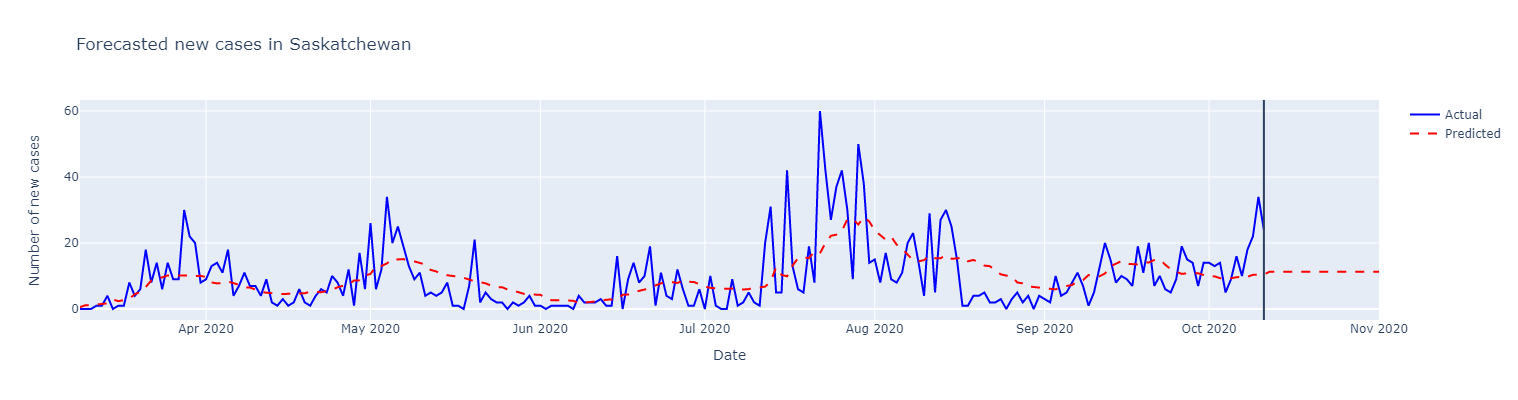

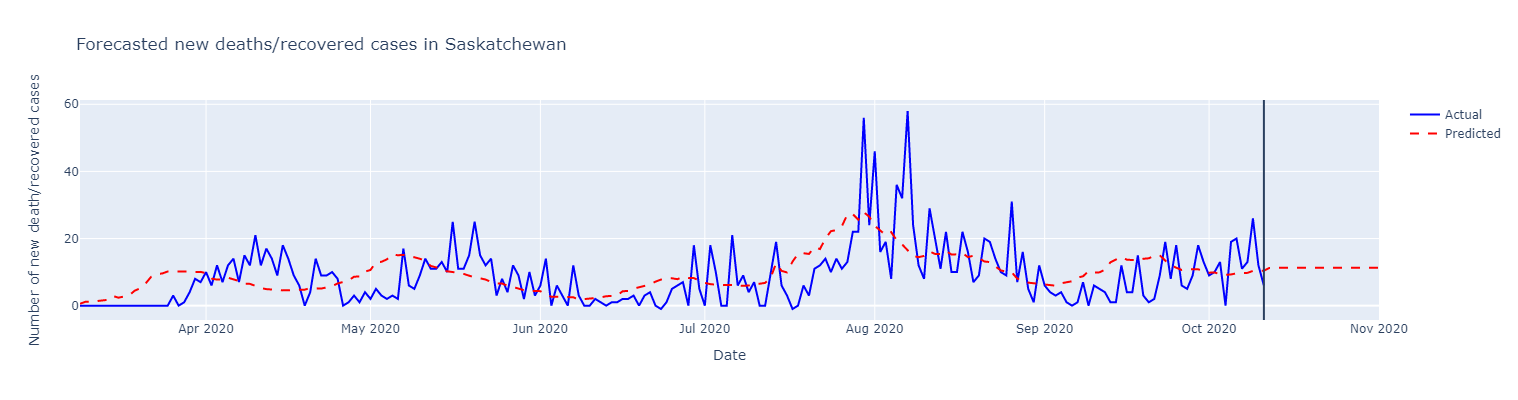

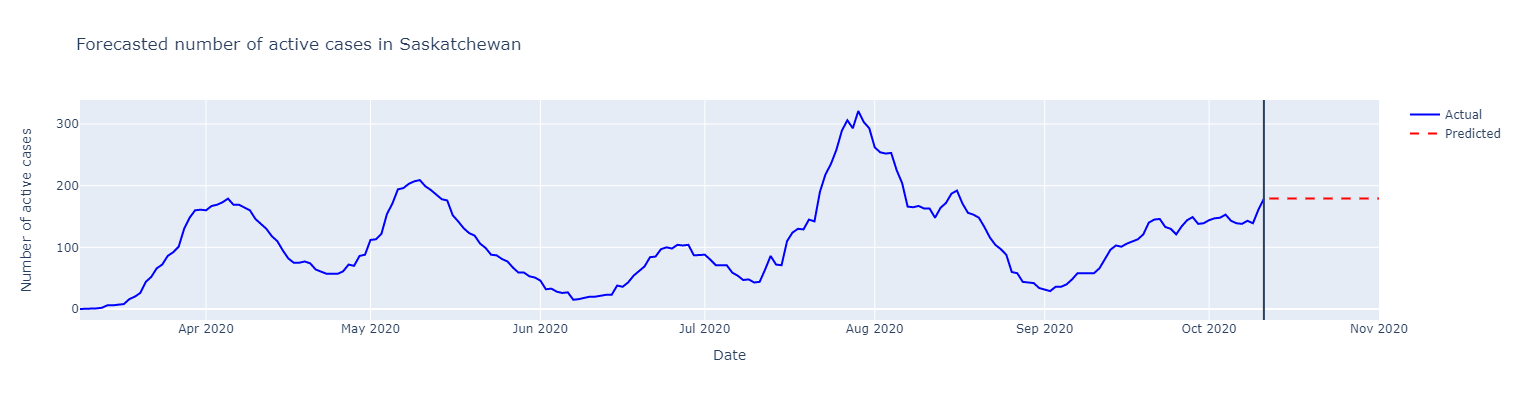

In [45]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query(f'province == "{province}"')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Cross validation